# Reproduction of Figure 2 of NPHC experimental results on the simulated dataset `Exp100`

In this notebook, we reproduce Figure 2 of the paper, shown below.

<img src="img/paper-fig2.png" style="width: 75%">

As stated in Section 3 of the [paper](https://arxiv.org/pdf/1607.06333.pdf), the `Exp100` dataset is a multivariate Hawkes process in $d=100$ with an integrated kernel matrix $G$ consisting of 3 triangular blocks as shown in the figure above with constant entries $\alpha = 0.1$. The parameters $\beta_i$ of each block are set to $\beta_0 = 0.1$ and $\beta_{i+1} = 10 \beta_i$ for subsequent blocks. The number of simulated events is equal to $10^5$ over the $d$ nodes.

In the experiments below, we carry out two sets of experiments with two different dimensions: first `Exp10` with $d=10$ dimensions as a proof of concept, and then `Exp100` with $d=100$ as reported on the picture above. We used $20$ realizations of $10^5$ events to fit the process, and we used an integration support of $H=40$ which seems to be a good value for the lower dimensional dataset `Exp10`.

---

Import libs

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import tick
from tick.hawkes.simulation import SimuHawkesExpKernels, SimuHawkesMulti
from tick.hawkes import HawkesCumulantMatching

Define helper functions to generate the dataset for some dimension `dim`

In [2]:
def build_parameters(dim):
    """Define the synthetic parameters as stated in the NPHC paper for dimension `dim`"""
    mu = 0.01       # Value of baseline rates
    alpha = 1/10    # Value of adjacency
    beta0 = 0.1     # Base beta of first block
    beta_mult = 10  # Multiplier for beta between blocks

    dim1 = int(dim * 0.5)  # dimension of block 1
    dim2 = int(dim * 0.3)  # dimension of block 2
    dim3 = int(dim * 0.2)  # dimension of block 3


    mus = mu * np.ones(dim)

    Alpha = np.zeros((dim, dim))
    Alpha[0:dim1, 0:dim1] = alpha * np.triu(np.ones((dim1, dim1)))
    Alpha[dim1:dim1+dim2, dim1:dim1+dim2] = alpha * np.tril(np.ones((dim2, dim2)))
    Alpha[dim1+dim2:dim1+dim2+dim3, dim1+dim2:dim1+dim2+dim3] = alpha * np.triu(np.ones((dim3, dim3)))

    Beta = np.zeros((dim, dim))
    Beta[0:dim1, 0:dim1] = np.triu(np.ones((dim1, dim1))) * beta0
    Beta[dim1:dim1+dim2, dim1:dim1+dim2] = np.tril(np.ones((dim2, dim2))) * beta0 * beta_mult
    Beta[dim1+dim2:dim1+dim2+dim3, dim1+dim2:dim1+dim2+dim3] = np.triu(np.ones((dim3, dim3))) * beta0 * beta_mult * beta_mult
    
    return mus, Alpha, Beta

## 1. Small `Exp10` dataset

Let us first experiment on a smaller 10-dimensional process.

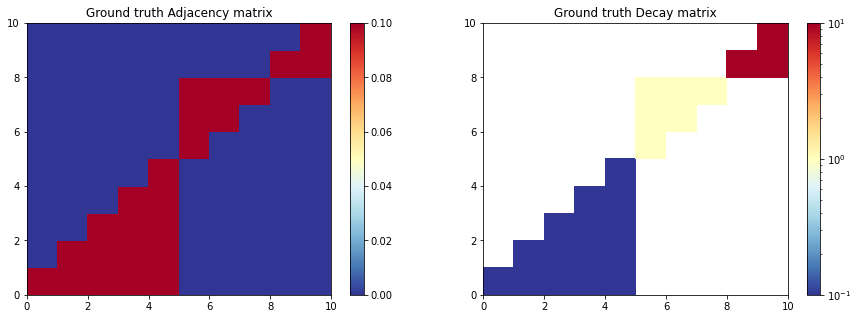

In [3]:
dim = 10
mus, Alpha, Beta = build_parameters(dim)

%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.sca(axs[0]);
plt.pcolor(Alpha, norm=colors.Normalize(vmin=0.0, vmax=Alpha.max()), cmap='RdYlBu_r');
plt.title('Ground truth Adjacency matrix')
plt.colorbar();
plt.sca(axs[1]);
plt.pcolor(Beta, norm=colors.LogNorm(vmin=Beta[Beta > 0].min(), vmax=Beta.max()), cmap='RdYlBu_r');
plt.title('Ground truth Decay matrix')
plt.colorbar();
plt.show();

Simulate a datasets of `n_realizations` with `max_jumps` per realization

In [4]:
max_jumps = 1e5      # Total number of jumps to simulate
n_realizations = 20  # Number of realizations to simulate

simu_hawkes = SimuHawkesExpKernels(baseline=mus, adjacency=Alpha, decays=Beta, 
                                   max_jumps=max_jumps, verbose=False)
multi = SimuHawkesMulti(simu_hawkes, n_simulations=n_realizations, n_threads=-1)
       
multi.simulate();

Fit the model using NPHC

In [5]:
# Integration support
H = 40

nphc = HawkesCumulantMatching(integration_support=H)
nphc.fit(multi.timestamps)

Instructions for updating:
Colocations handled automatically by placer.


Visualize the results

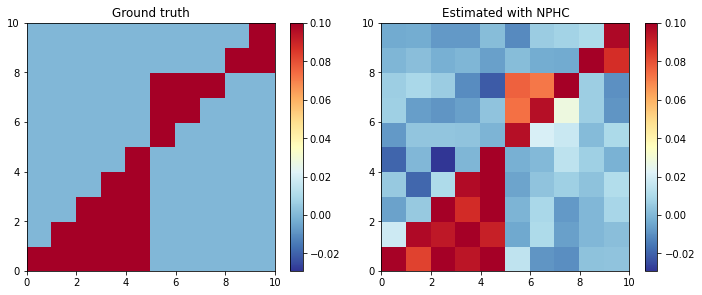

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

vmin = min(Alpha.min(), nphc.adjacency.min())
vmax = min(Alpha.max(), nphc.adjacency.max())
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = 'RdYlBu_r'

plt.sca(axs[0])
axs[0].set_aspect('equal')
plt.pcolor(Alpha, norm=norm, cmap=cmap)
plt.title('Ground truth')
plt.colorbar()
plt.sca(axs[1])
axs[1].set_aspect('equal')
plt.pcolor(nphc.adjacency, norm=norm, cmap=cmap)
plt.title('Estimated with NPHC')
plt.colorbar()
fig.tight_layout();

In [7]:
del dim, mus, Alpha, Beta, max_jumps, n_realizations, H

---

## 2. Larger `Exp100` dataset

A larger dimensional process with $d=100$ with an adjacency matrix that is a block-matrix composed of lower and upper trianguler blocks with constant value.

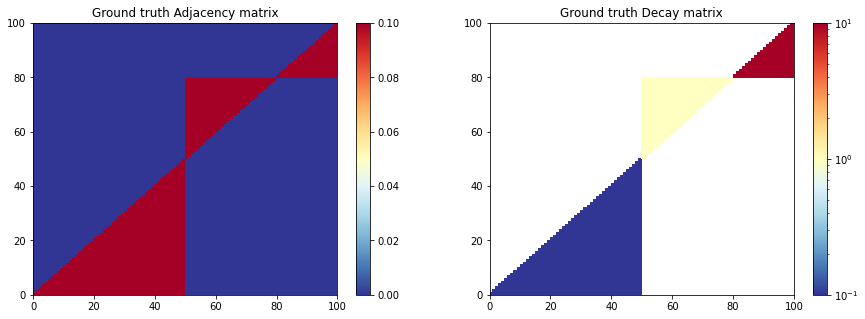

In [8]:
dim = 100
mus, Alpha, Beta = build_parameters(dim)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.sca(axs[0]);
plt.pcolor(Alpha, norm=colors.Normalize(vmin=0.0, vmax=Alpha.max()), cmap='RdYlBu_r');
plt.title('Ground truth Adjacency matrix')
plt.colorbar();
plt.sca(axs[1]);
plt.pcolor(Beta, norm=colors.LogNorm(vmin=Beta[Beta > 0].min(), vmax=Beta.max()), cmap='RdYlBu_r');
plt.title('Ground truth Decay matrix')
plt.colorbar();

Simulate a datasets of `n_realizations` with `max_jumps` per realization

In [9]:
max_jumps = 1e5                       # Total number of jumps to simulate
n_realizations = 20                   # Number of realizations to simulate

simu_hawkes = SimuHawkesExpKernels(baseline=mus, adjacency=Alpha, decays=Beta, 
                                   max_jumps=max_jumps, verbose=False)
multi = SimuHawkesMulti(simu_hawkes, n_simulations=n_realizations, n_threads=-1)
multi.simulate();

Fit the model using NPHC

In [10]:
# Integration support
H = 40

nphc = HawkesCumulantMatching(integration_support=H)
nphc.fit(multi.timestamps)

Visualize the results

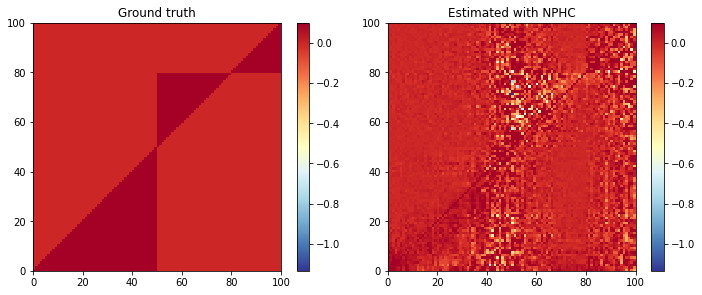

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

vmin = min(Alpha.min(), nphc.adjacency.min())
vmax = min(Alpha.max(), nphc.adjacency.max())
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = 'RdYlBu_r'

plt.sca(axs[0])
axs[0].set_aspect('equal')
plt.pcolor(Alpha, norm=norm, cmap=cmap)
plt.title('Ground truth')
plt.colorbar()
plt.sca(axs[1])
axs[1].set_aspect('equal')
plt.pcolor(nphc.adjacency, norm=norm, cmap=cmap)
plt.title('Estimated with NPHC')
plt.colorbar()
fig.tight_layout();